In this notebook I will be evaluating my two models: Inductive Matrix Factorization and IGMC.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from models import MF_inc, IGMC
import tensorflow as tf
import keras
from scipy.sparse import csr_matrix, coo_matrix, lil_matrix, csc_matrix
from graph_extraction import *

from spektral.data import Dataset, DisjointLoader, Graph, BatchLoader
from spektral.data.utils import to_disjoint

In [4]:
users = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)

In [5]:
users.shape

(1534489, 4)

In [6]:
users.head()

,UserID,AnimeID,Score,User_Mapped
0,1,102,7,0
1,1,3229,5,0
2,1,4730,6,0
3,1,589,10,0
4,1,182,7,0


In [7]:
users.UserID.unique()

array([   1,   10, 1000, ..., 9993, 9996, 9998], dtype=int64)

We shuffle the users as we did for training the IGMC algorithm, and select all the users that weren't used for training or validation, ie. mapped users 6000 and on.

In [8]:
users_test = users[users.User_Mapped.isin(shuffle(users.User_Mapped.unique(),random_state=42)[6000:])]

In [9]:
vc = users_test.UserID.value_counts()

In [8]:
users_test['vc'] = users_test.apply(lambda x: vc[x[0]],axis=1)

C:\Users\nickj\AppData\Local\Temp\ipykernel_15328\2813286631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_test['vc'] = users_test.apply(lambda x: vc[x[0]],axis=1)


In [9]:
users_test.head()

,UserID,AnimeID,Score,User_Mapped,vc
232,10000,221,9,3,28
233,10000,1380,6,3,28
234,10000,274,7,3,28
235,10000,61,10,3,28
236,10000,472,9,3,28


The test users are filtered by the number of anime they've watched, since we'll be needing to split them into 'known' and 'unknown' ratings for the testing process, and there need to be a substantial amount in each subset.

In [10]:
users_test = users_test[users_test.vc >= 100]
users_test = users_test.drop('vc',axis=1)

In [11]:
users_test.head()

,UserID,AnimeID,Score,User_Mapped
260,10001,61,10,4
261,10001,1318,6,4
262,10001,4887,6,4
263,10001,2107,6,4
264,10001,1491,6,4


In [12]:
len(users_test.UserID.unique())

988

Now we need to split the test users into data that already 'exists' that can be fed into the algorithm to establish the user's preferences, and 'unseen' data that we are trying to predict as accurately as possible. The cutoff will be set to half the total data if the number of entries for the user is lower than 200, otherwise it will be set to 100.

In [13]:
for user in users_test.User_Mapped.unique():
    userdata = users_test[users_test['User_Mapped'] == user]
    if len(userdata) <= 200:
        cutoff = int(len(userdata)/2)
    else:
        cutoff = 100
    userdata.iloc[:cutoff,:].to_csv('holdout_known/User_'+str(user)+'.csv')
    userdata.iloc[cutoff:,:].to_csv('holdout_unknown/User_'+str(user)+'.csv')
    

As a means of initial comparison, I will implement a simple 'random' model.

In [36]:
def random_model():
    users = 0
    APsum = 0
    for filename in os.listdir('holdout_unknown'):
        users += 1
        f_known = pd.read_csv('holdout_known/' + filename)
        f_unknown = pd.read_csv('holdout_unknown/' + filename)
        f_unknown = f_unknown.sample(frac=1,random_state=42)
        f_unknown = zscore(f_known,f_unknown)
        
        largest = f_unknown.iloc[:5,:]
        
        print(largest)
         # calculate MAP
        rel = 0
        AP = 0
        for i in largest.index:
            rel += relevance(largest.loc[i,'Score'],largest.loc[i,'Zscore'])
            AP += (rel/(i+1))
        AP = AP/len(largest)
            
        APsum += AP
        MAP = APsum/users
        #print(MAP)
    print(MAP)

In [ ]:
random_model()

MAP: 0.1084382679466956

The function below determines whether an anime is 'relevant' to a particular user, relevance being determined by a score above 9 or a standardized score above 0.5.

In [21]:
def relevance(score,zscore):
    if score >= 9:
        return 1
    elif zscore >= 0.5:
        return 1
    else:
        return 0

The function below calculates the standardized score for unknown data from the mean and standard deviation of the known data.

In [11]:
def zscore(known,unknown):
    zmean = known['Score'].mean()
    zstd = known['Score'].std()
    unknown['Zscore'] = (unknown['Score'] - zmean)/zstd
    return unknown

Now, it's time to evaluate my primary models: Matrix Factorization and IGMC.

First, evaluate Matrix Factorization using one-sided least squares.

The code below is necessary in order to reload the saved model weights for the final Matrix Factorization model. There may be a more succinct way to achieve this, but this format serves the purpose.

In [21]:
df = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)
anime = pd.read_csv('anime_REINDEXED.csv',index_col=0)
data = df[df.User_Mapped.isin(shuffle(df.User_Mapped.unique(),random_state=42)[:6000])]

user_mapping = {v: k-1 for k, v in enumerate(data['UserID'].unique(), 1)}
data['User_Mapped_MF'] = data.UserID.replace(user_mapping)
data = data.sample(frac=1,random_state=42)

train_data = data.iloc[:int(len(data)*0.9),:]
val_data = data.iloc[int(len(data)*0.9):,:]

N = len(data['User_Mapped_MF'].unique())
M = anime.shape[0]
mu = train_data.Score.mean()
model_reg = [0,0]

mf = MF_inc(20,N,M,model_reg,mu)
mf.create_model()
mf.model.load_weights('checkpoints/model_mf.h5')

C:\Users\nickj\AppData\Local\Temp\ipykernel_11236\3688267544.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['User_Mapped_MF'] = data.UserID.replace(user_mapping)


The function below evaluates the Matrix Factorization update method. It calculates both the squared error and MAP for the unknown data. The Final RMSE is calculated by dividing the squared error by the count and taking the square root.

In [40]:
def evaluate_MF():
    count = 0
    sqerror = 0
    users = 0
    APsum = 0
    MAP = 0
    for f in os.listdir('holdout_known'):
        users += 1
        known = pd.read_csv('holdout_known/' + f)
        unknown = pd.read_csv('holdout_unknown/' + f)
        zmean = known['Score'].mean()
        zstd = known['Score'].std()
        unknown['Zscore'] = (unknown['Score'] - zmean)/zstd
        known_data = [(known.loc[i,'AnimeID'],known.loc[i,'Score']) for i in known.index]
        unknown_data = [(unknown.loc[i,'AnimeID'],unknown.loc[i,'Score']) for i in unknown.index]
        recs = mf.update(data=known_data,reg=1)
        unknown['Prediction'] = unknown['AnimeID'].apply(lambda x: recs[x][0])
        print(unknown['Prediction'])
        largest = unknown.nlargest(5,'Prediction')
        
        print(largest)
        # calculate mse
        for d in unknown_data:
            try:
                sqerror += (min(recs[d[0]],10)-d[1])**2
                count += 1
            except:
                continue

        # calculate MAP
        rel = 0
        AP = 0
        for i in range(len(largest.index)):
            rel += relevance(largest.loc[largest.index[i],'Score'],largest.loc[largest.index[i],'Zscore'])
            AP += (rel/(i+1))
        AP = AP/len(largest)

        APsum += AP
        MAP = APsum/users

        print(sqerror)
        print(count)
        print(MAP)

In [ ]:
evaluate_MF()

SE: 306117.56515479
Count: 184027
MAP: 0.6917341430499321

The results for the Matrix Factorization model are shown below.

In [10]:
print('RMSE: ' + str(np.sqrt(306117.56515479/184027)))
print('MAP: ' + str(0.6917341430499321))

RMSE: 1.289743512418556
MAP: 0.6917341430499321


Next, evaluate the IGMC model.

In order to reload the saved weights, I first need to start running the model to initialize the weights, the methods below are from 

In [2]:
def train_step(inputs,target,step):
    """
    This function computes a training step via calling the model on the input batch, with training set to True,
    and comparing the predictions to the target value, in addition to the regularization loss computed by
    the adjacent regularization term, which limits the magnitude of the difference between weight values corresponding
    to adjacent ratings (eg. 5,6 or 9,10).
    
    Tensorflow's GradientTape class is used to implement the training and feeding the gradients back into the optimizer
    to adjust the weights.

    """
    tf.config.run_functions_eagerly(True)
    if step%200 == 0:
        print(target)
    with tf.GradientTape() as tape:
        predictions = model(inputs,training=True)
        reg_loss = 0
        for conv in model.convs:
            coeffs = conv.r_kernels
            reg_loss += ARRNorm(0.00001,coeffs)
        loss = loss_fn(target,tf.transpose(predictions))
        total_loss = loss + reg_loss
    if step%200 == 0:
        print(predictions)
        print(f"Loss: {loss}, reg loss: {reg_loss}")
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [3]:
class CustomGenerator(tf.keras.utils.Sequence):
    """
    This class generates the data for the deep learning model to learn from.
    
    The data is either for training or validation, determined by one of the arguments to init. The 
    methods to construct the enclosing subgraphs are called for each batch of data, and these graphs are fed
    into the machine learning algorithm in disjoint form (ie. as one large matrix, since this is how some of the underlying
    layers best handle the data).
    
    I limited the batch size to 8, since in disjoint form a lot of memory is used, and I didn't want to overload my
    laptop.
    """
    def __init__(self,data,anime,csr,batch_size=8,data_type='train',split=0.9):
        self.batch_size = batch_size
        if data_type == 'train':
            self.data = data.iloc[:int(len(data)*split),:]
        elif data_type == 'val':
            self.data = data.iloc[int(len(data)*split):,:]
            
        self.anime = anime
        self.csr = csr
        self.sg = EnclosingSubgraph(csr)
        self.sg.index_rows_cols()
        self.valid = self.data.shape[0]
        
    def __len__(self):
        l = int(np.floor(self.valid/self.batch_size))
        return l
    
    def __getitem__(self,idx):
        idxs = [item for item in range(idx*self.batch_size,(idx+1)*self.batch_size)] 
        g_list = []
        x_list = []
        a_list = []
        t_list = []
        for i,j in zip(self.data.UserID.iloc[idxs],self.data.AnimeID.iloc[idxs]):
            r = self.csr[i,j]
            temp = self.sg.extract_graph(edge=(i,j),Arow=self.sg.data_r,Acol=self.sg.data_c,num_hops=1,g_label=r,max_nodes_per_hop=600)
            if temp != None:
                g = self.sg.make_sp_graph(temp[0],temp[1],temp[2],temp[3],temp[4],temp[5])
                #g_list.append([g.x,to_sparse_tensor(g.a)])
                x_list.append(g.x)
                a_list.append(g.a)
                t_list.append(g.y)
        if len(t_list) == 0:
            return None
        return [to_disjoint(x_list,a_list),t_list]

In [4]:
def ARRNorm(strength,coeffs):
    """
    This function limits the difference in weights for adjacent ratings by applying a penalty.  It's controlled
    by a strength parameter.
    """
    reg = 0
    for i in range(len(coeffs)-1):
        reg += tf.norm((coeffs[i] - coeffs[i+1]))**2
    return strength*reg

This method is use to run a single evaluation step for the IGMC model, whereby the input enclosing subgraph is fed into the model, and the loss and predicted value are output.

In [5]:
def eval_step(inputs,target):
    prediction = model(inputs,training=False)
    loss = loss_fn(target,prediction)
    return ((loss,prediction))

In [ ]:
data = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)
anime = pd.read_csv('anime_REINDEXED.csv',index_col=0)
data = data[data.User_Mapped.isin(shuffle(data.User_Mapped.unique(),random_state=42)[:6000])]
unq = data.User_Mapped.unique()

for i in range(len(unq)):
    print(i)
    data.UserID[data.User_Mapped == unq[i]] = i

shape = (data['UserID'].max()+1,len(anime))
coo = coo_matrix((data["Score"], (data["UserID"], data["AnimeID"])), shape=shape)
csr = coo.tocsr()

data = data.sample(frac=1,random_state=42)

In [ ]:
model = IGMC()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025)
train_gen = CustomGenerator(data=data,anime=anime,csr=csr,batch_size=4,data_type='train')

step = 1
for batch in train_gen.__iter__():
    if step == 2:
        print("Loading Weights...")
        model.load_weights('checkpoints/model_1m/epoch_' + str(5) + '.h5')
            # for i,w in enumerate(model.coefficients):
            #     print(i,w.name,w)
        for i,conv in enumerate(model.convs):
            print(i)
            coeffs = []
            for coeff in conv.coefficients:
                coeffs.append(coeff.numpy())
            print(coeffs)
            break
                
    loss = train_step(*batch,step)
    step += 1
    if step > 2:
        break

for layer in model.layers:
    print(layer.weights)

The code below evaluates the IGMC model, calculating both the MSE and the MAP score on the unknown data.

First, the training data is loaded as before to construct the underlying csr matrix.

In [ ]:
data = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)
anime = pd.read_csv('anime_REINDEXED.csv',index_col=0)
data = data[data.User_Mapped.isin(shuffle(data.User_Mapped.unique(),random_state=42)[:6000])]
unq = data.User_Mapped.unique()

for i in range(len(unq)):
    print(i)
    data.UserID[data.User_Mapped == unq[i]] = i

shape = (data['UserID'].max()+1,len(anime))
coo = coo_matrix((data["Score"], (data["UserID"], data["AnimeID"])), shape=shape)
csr = coo.tocsr()

Now, the test users are iterated over, constructing an enclosing subgraph from the training data and the known scores from the test user, with the aim of predicting the remaining unknown anime scores for that user.

The code computes the MSE and the MAP scores for the entire unknown dataset.

In [ ]:
sqerror = 0
count = 0
users = 0
APsum = 0

#iterate over all test users
for f in os.listdir('holdout_known'):
    users += 1
    recs = {}
    sg = EnclosingSubgraph(csr)
    known = pd.read_csv('holdout_known/' + f)
    unknown = pd.read_csv('holdout_unknown/' + f)
    
    zmean = known['Score'].mean()
    zstd = known['Score'].std()
    unknown['Zscore'] = (unknown['Score'] - zmean)/zstd
    
    arr = np.zeros(len(anime))
    for i in known.index:
        np.put(arr,known.loc[i,'AnimeID'],known.loc[i,'Score'])
    arr = arr.astype(int)
    print(arr.dtype)
    sg_temp = sg
    
    sg_temp.append_new_user([arr],0) #this line appends the known data for the test user to the csr matrix, allowing predictions to be made for that user
    sg_temp.index_rows_cols()
    
    #iterate over every unseen anime for the current user
    for i in unknown.index:
        unum = 6000
        anum = unknown.loc[i,'AnimeID']
        rating = unknown.loc[i,'Score']
        
        #generate the enclosing subgraph for the user-anime pair to be fed into the IGMC model, and get the loss and prediction 
        try:
            temp = sg_temp.extract_graph(edge=(unum,anum),Arow=sg_temp.data_r,Acol=sg_temp.data_c,num_hops=1,g_label=rating,max_nodes_per_hop=600)
            g = sg_temp.make_sp_graph(temp[0],temp[1],temp[2],temp[3],temp[4],temp[5])
            g_format = [(g.x,g.a),g.y]
            loss,prediction = eval_step(g_format[0],g_format[1])
        except:
            continue
            
        #calculate the mse
        sqerror += loss
        count += 1
        mse = sqerror/count
        if count % 100 == 0:
            print("Count:" + str(count))
            print(loss)
            print(rating)
            print(prediction)
            print("MSE: ")
            print(mse)
        
        recs[anum] = prediction
        
    unknown['Prediction'] = unknown['AnimeID'].apply(lambda x: recs[x].numpy()[0][0] if x in recs.keys() else 0)
    print(unknown['Prediction'])
    largest = unknown.nlargest(5,'Prediction')
    
    #calculate the MAP for the 5 largest predictions
    rel = 0
    AP = 0
    for i in range(len(largest.index)):
        rel += relevance(largest.loc[largest.index[i],'Score'],largest.loc[largest.index[i],'Zscore'])
        AP += (rel/(i+1))
    AP = AP/len(largest)

    APsum += AP
    MAP = APsum/users
    
    print("MSE: " + str(mse))
    print("MAP: " + str(MAP))
    
        
        
        
        

MSE: tf.Tensor(1.5173337, shape=(), dtype=float32)
MAP: 0.7558906882591093

As can be seen below, both the RMSE and MAP scores show a notable improvement over the Matrix Factorization model. Unfortunately, the IGMC model takes a lot longer to run, so there is a clear tradeoff between predictive accuracy and runtime.

In [11]:
print('RMSE: ' + str(np.sqrt(1.5173337)))
print('MAP: ' + str(0.7558907))

RMSE: 1.2318009985383191
MAP: 0.7558907


In [4]:
results = pd.DataFrame(index=["MF","IGMC"],columns=["RMSE","MAP"],data=[[1.290,0.691],[1.231,0.756]])
print(results)


       RMSE    MAP
MF    1.290  0.691
IGMC  1.231  0.756


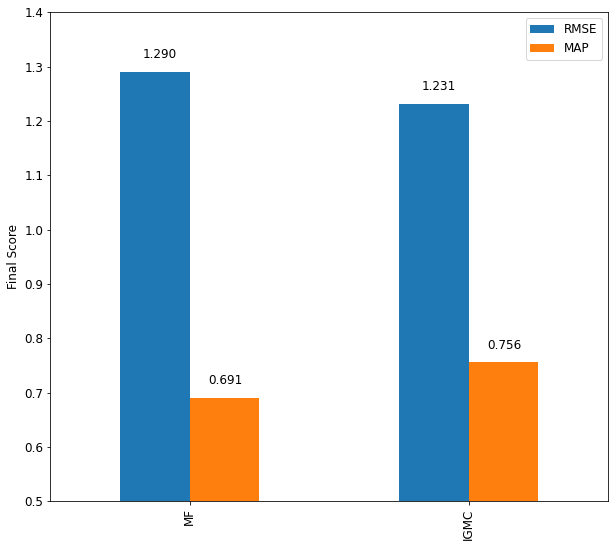

In [45]:
fig,ax = plt.subplots(figsize =(10, 9))
ax.set_ylim([0.5,1.4])
results.plot.bar(ax=ax)
plt.ylabel("Final Score")

plt.text(-0.167,1.290+0.025,'1.290')
plt.text(0.067,0.691+0.025,'0.691')
plt.text(1-0.167,1.231+0.025,'1.231')
plt.text(1+0.067,0.756+0.025,'0.756')

plt.rcParams.update({'font.size': 12}) 
